## Project 3 ## 
**Step 03: Modeling Data**

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
pd.options.display.max_colwidth = 100

In [95]:
no_blanks = pd.read_csv('../data/no_blanks.csv')

Calculating the baseline accuracy for our model. It's 60% (subsim) / 40% (cascon) split.  Our models need to predict class 1 (subsim) more than 60% of the time because we would get 60% just by guessing each is subsim doc.

In [96]:
no_blanks['subreddit'].value_counts(normalize = True)

1    0.603582
0    0.396418
Name: subreddit, dtype: float64

In [97]:
no_blanks['subreddit'].value_counts()

1    4921
0    3232
Name: subreddit, dtype: int64

In [98]:
#  Looks like Subsim docs (length of title + post) are about 160 characters longer than Cascon
no_blanks.groupby('subreddit').mean()

,Unnamed: 0,created_utc,post_length
subreddit,,,
0,7481.89078,1.641160e+09,689.200804
1,2460.36964,1.628508e+09,849.342004


In [99]:
# Setting up variables for modeling
X = no_blanks['doc']
y = no_blanks['subreddit']

In [100]:
# Splitting the data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   stratify=y)

In [101]:
X_train.shape, y_train.shape

((6114,), (6114,))

In [102]:
X_test.shape, y_test.shape

((2039,), (2039,))

In [103]:
# Instantiate a CountVectorizer with the default hyperparameters.
# Keeps all the stop words; default tokens
cvec = CountVectorizer()

In [104]:
# Fit the vectorizer on the corpus.
cvec.fit(X_train)

CountVectorizer()

In [105]:
#21,553 words
len(cvec.get_feature_names())

21513

In [106]:
# Transforming the data to a sparse array for analysis
X_train_trans = cvec.transform(X_train)

In [112]:
X_test_trans = cvec.transform(X_test)

In [108]:
# convert training data to dataframe (densifying columns again to view)
X_train_trans_df = pd.DataFrame(X_train_trans.todense(), 
                          columns=cvec.get_feature_names())

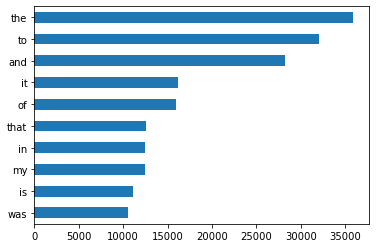

In [109]:
# plot top occuring words in Casual Conversations
X_train_trans_df.sum().sort_values(ascending=True).tail(10).plot(kind='barh');

## Model Using the CountVectorizer and Multinomial Naive Bayes

In [27]:
# Default countvectorizer params:  
#    stop_words=None, min_df=1, max_df=1, max_features=None, ngram_range=1,1
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [28]:
# fitting 3*2*2*2 = 24 models
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 9_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.8, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
}

In [29]:
gs = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 cv=5)

In [30]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.8, 0.95],
                         'cvec__max_features': [2000, 3000, 9000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [31]:
print(gs.best_params_)

{'cvec__max_df': 0.95, 'cvec__max_features': 9000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}


In [32]:
print(gs.best_score_)

0.8936844683126063


In [33]:
print(gs.best_estimator_)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.95, max_features=9000, min_df=2)),
                ('nb', MultinomialNB())])


In [35]:
# Score model on training set and test set.
print('Training Score:' ,gs.score(X_train, y_train)),
print('Test Score:', gs.score(X_test, y_test))

Training Score: 0.9329407916257769
Test Score: 0.8788621873467386


In [36]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate the specificity
spec = tn / (tn + fp)
print('Specificity:', spec)

# Calculate the sensitivity
sens = tp / (tp + fn)
print('Sensitivity:', sens)

Specificity: 0.900990099009901
Sensitivity: 0.8643379366368806


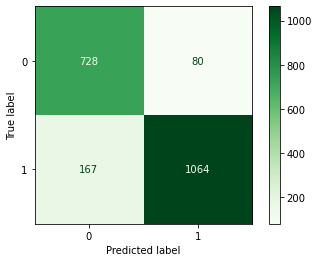

In [37]:
# View confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap="Greens", values_format='d');

## Model Using Multinomial Naive Bayes & Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer ##
**Estimator: Multinomial Naive Bayes (MNB). Note there's a violation of MNB assumptions since TF_IDF scores in fractions not integers.  Still will probably work.  

In [38]:
# Instantiate and fit the transformer.
tvec = TfidfVectorizer()

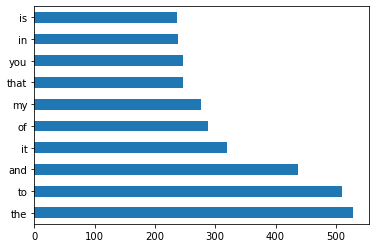

In [39]:
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [40]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [41]:
# Search over the following values of hyperparameters:

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 9_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.8, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
}

In [42]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                       param_grid = pipe_tvec_params, # what parameters values are we searching?
                       n_jobs = -1,
                       cv=5) # 5-fold cross-validation.

In [43]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.8, 0.95],
                         'tvec__max_features': [2000, 3000, 9000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [44]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.9345763820739287

In [45]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.8852378616969102

In [46]:
# Best Score:
print(gs_tvec.best_params_)
print(gs_tvec.best_score_)
print(gs_tvec.best_estimator_)

{'tvec__max_df': 0.8, 'tvec__max_features': 9000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
0.8863259163897637
Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=9000, min_df=2,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])


In [47]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity
spec = tn / (tn + fp)
print('Specificity:', spec)

# Calculate the sensitivity
sens = tp / (tp + fn)
print('Sensitivity:', sens)

Specificity: 0.7957920792079208
Sensitivity: 0.9439480097481722


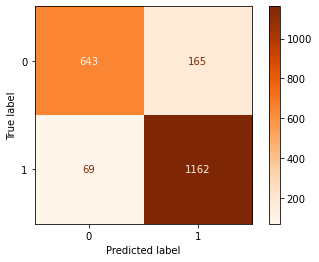

In [48]:
# visualize this

plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Oranges', values_format='d');

## Logistic Regression w/ CountVectorizer()

In [8]:
# Default countvectorizer params:  
#    stop_words=None, min_df=1, max_df=1, max_features=None, ngram_range=1,1
pipe_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [10]:
pipe_lr.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'lr': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [11]:
# # fitting 3*2*2*2 = 24 models
# pipe_params_lr = {
#     'cvec__max_features': [2_000, 3_000, 9_000],
#     'cvec__min_df': [2, 3],
#     'cvec__max_df': [.8, .95],
#     'cvec__ngram_range': [(1,1), (1,2)],
#     'lr': [LogisticRegression()],
#     'lr__max_iter': [1000,2000,4000]
# }

In [87]:
# fitting 3*2*2*2 = 24 models
pipe_params_lr = {
    'cvec__max_features': [6000, 9000],
    'cvec__min_df': [2],
    'cvec__max_df': [0.6, 0.7],
    'cvec__ngram_range': [(1,2)],
    'lr': [LogisticRegression()],
    'lr__max_iter': [3000],
    'lr__C': np.logspace(-3,3,3), #[0.01]
    #"lr__penalty": ['l1','l2'], #['none']
    #'lr__solver': ['liblinear']
}

In [88]:
gs_lr = GridSearchCV(pipe_lr, param_grid= pipe_params_lr)

In [89]:
gs_lr.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.6, 0.7],
                         'cvec__max_features': [6000, 9000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)],
                         'lr': [LogisticRegression(max_iter=3000)],
                         'lr__C': array([1.e-03, 1.e+00, 1.e+03]),
                         'lr__max_iter': [3000]})

In [90]:
gs_lr.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 9000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'lr': LogisticRegression(max_iter=3000),
 'lr__C': 1.0,
 'lr__max_iter': 3000}

In [91]:
gs_lr.score(X_train, y_train)

0.9998364409551849

In [92]:
gs_lr.score(X_test, y_test)

0.898970083374203

In [110]:
#Ridge Regularization with C strength = 10 (a grid of C values)
logreg = LogisticRegressionCV(cv=5,max_iter = 2000)

In [111]:
logreg.fit(X_train_trans, y_train)

LogisticRegressionCV(cv=5, max_iter=2000)

In [113]:
print(logreg.score(X_train_trans, y_train))
print(logreg.score(X_test_trans, y_test))

0.9960745829244357
0.9033840117704757


In [18]:
# Get predictions
preds_logreg = logreg.predict(X_test_trans_cvec)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_logreg).ravel()

# Calculate the specificity
spec = tn / (tn + fp)
print('Specificity:', spec)

# Calculate the sensitivity
sens = tp / (tp + fn)
print('Sensitivity:', sens)

Specificity: 0.8688118811881188
Sensitivity: 0.925264012997563


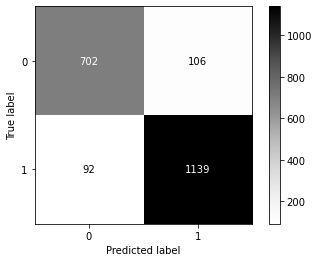

In [21]:
# visualize this
plot_confusion_matrix(logreg, X_test_trans_cvec, y_test, cmap='Greys', values_format='d');

## Random Forest Model

*Set up a pipeline with CountVectorizer and two more estimators:
Random Forest and SVC*
**Thank you to the good people on Stack Exchange:**
https://stackoverflow.com/questions/61681254/how-to-use-gridsearchcv-for-comparing-multiple-models-along-with-pipeline-and-hy

In [5]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [26]:
pipe_rf.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight

In [7]:
params_rf = [
    {
        'cvec__max_features': [2_000, 3_000, 9000],
        'cvec__min_df': [1, 2, 3],
        'cvec__max_df': [.8, .95],
        'cvec__ngram_range': [(1,1), (1,2)],
        'rf': [RandomForestClassifier()],
        'rf__n_estimators': [100, 300],
        'rf__max_depth': [None, 1, 5]
    }
]

In [8]:
gs_rf = GridSearchCV(
    pipe_rf, param_grid=params_rf, cv=5, scoring='accuracy'
)

In [ ]:
gs_rf.fit(X_train, y_train)

/Users/JFS/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
print(gs_rf.best_score_)
gs_rf.best_params_

In [299]:
gs_rf.score(X_train, y_train)

1.0

In [295]:
gs_rf.score(X_test, y_test)

0.8616969102501226

In [302]:
# Get predictions
rf_preds = rf_gs.predict(X_test_trans_cvec)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()

# Calculate the specificity
spec = tn / (tn + fp)
print('Specificity:', spec)

# Calculate the sensitivity
sens = tp / (tp + fn)
print('Sensitivity:', sens)

Specificity: 0.6608910891089109
Sensitivity: 0.9634443541835905


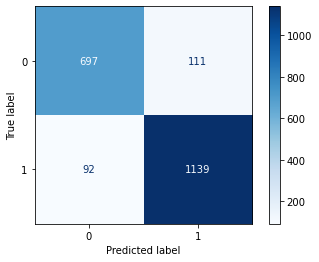

In [189]:
# visualize this
plot_confusion_matrix(logreg, X_test_trans_cvec, y_test, cmap='Blues', values_format='d');